## Import Packages and dataset

In [1]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import random
import sys
import seaborn as sns

from Utils import AudioUtil

from tensorflow.keras import metrics

In [2]:
main_dir=os.getcwd()
train_dir=main_dir+'\\train'
print('{}\n{}'.format(main_dir,train_dir))

c:\Users\david\Desktop\LOOP_Q_PRIZE
c:\Users\david\Desktop\LOOP_Q_PRIZE\train


First of all I remove the rows that contains Nan values and the 168th, whose auido file is silent

Rows with Nan values :


,file_id,emotion,origin
8937,b78b41bd-3c6f-4182-94ac-430bad71f4e0.wav,NaN,tess


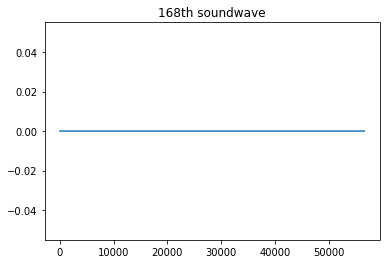


Number of rows after having cleaned the Dataset: 10109

A sample from the Dataset:


,file_id,emotion,origin
5904,da3ecf6b-f5bb-4d7a-a554-f4c8dc6a7076.wav,fear,crema
6854,d573d7e4-0859-4a09-8429-1e900e93b646.wav,happy,ravdess
9913,dc0a5320-fed0-49f0-9d1c-3b8b583e5c72.wav,surprise,tess
3033,666e9c34-b8ef-4935-874a-63c6cfb262d7.wav,fear,crema
406,2474d264-d1dc-484e-828a-001bfa718e9f.wav,happy,crema
2461,3269aa6c-bf59-4fd1-9dad-19aa31e00a73.wav,angry,crema
3789,24f93958-9c2d-4773-8182-fb64867e508f.wav,disgust,crema
5429,a5bc308b-c03d-4925-b679-59ed4d0f92c3.wav,happy,crema
674,3859fb99-73d1-4aeb-89fe-7114fb1feb46.wav,disgust,crema
4464,dd7b9624-1bc4-4093-a6e7-3cb01759e298.wav,disgust,crema


In [3]:
train_df = pd.read_csv(main_dir+'\\2022challengeA_train.csv', index_col=0)

print('Rows with Nan values :')
display(train_df[train_df.isna().any(axis=1)])
train_df=train_df.dropna()


print('\n')
aud = librosa.load(train_dir + '\\' + train_df['file_id'].iloc[168])
plt.plot(aud[0])
plt.title('168th soundwave')
plt.show()
train_df = train_df.drop([168], axis = 0)
train_df.index=range(len(train_df))

print('\nNumber of rows after having cleaned the Dataset: {}'.format(train_df.shape[0]))
#train_df=train_df[['file_id', 'class']]
print('\nA sample from the Dataset:')
display(train_df.sample(10))


Having a look at a soundwave per origin

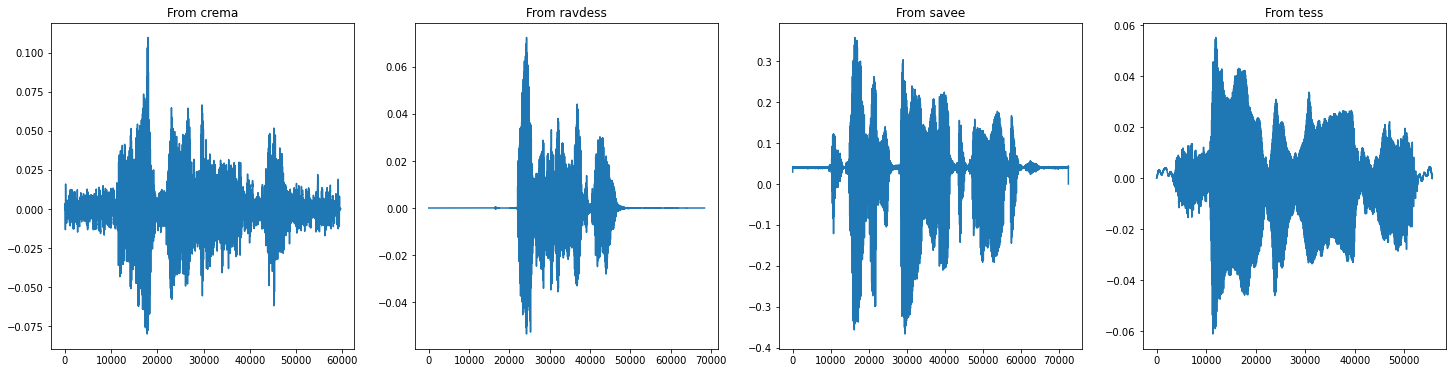

In [4]:
fig, axs = plt.subplots(1, 4, figsize = (25, 6))

i=0
for origin in np.unique(train_df['origin']):
    df = train_df[train_df['origin']==origin]
    aud = librosa.load(train_dir + '\\' + df['file_id'].iloc[random.randint(0,len(df))])
    axs[i].plot(aud[0])
    axs[i].set_title('From ' + origin)
    i+=1


It is evident that there is a high varibility of volumes between origins

## Analysis

First of all I search correlations between the origin, the emotion and some chaarcteristic of the audio file.

To do so I need to extract some metric:
- Sampling rate of the recording
- Duration of the recording
- Mean of the soundwave
- Standard deviation of the soundwave
- Maximum peak of the soundwave

In [5]:
# Initialize mean, peak, std, number of samples, sampling rate and duration

duration = np.zeros(shape = len(train_df))
n_samples = np.zeros(shape = len(train_df))
sampling_rate = np.zeros(shape = len(train_df))
peak = np.zeros(shape = len(train_df))
mean = np.zeros(shape = len(train_df))
std = np.zeros(shape = len(train_df))


for i in range(len(train_df)):
    audio_file = train_dir + '\\' + train_df['file_id'][i]
    samples, sr = librosa.load(audio_file, sr=None)
    duration[i] = len(samples)/sr
    n_samples[i] = len(samples)
    sampling_rate[i] = sr
    peak[i] = np.max(np.abs(samples))
    mean[i] = np.mean(samples)
    std[i] = np.std(samples)

train_df['duration']=duration
train_df['n_samples']=n_samples.astype(int)
train_df['sr']=sampling_rate
train_df['peak']=peak
train_df['mean']=mean
train_df['std']=std

# Adding a categorical encoding of origin and emotion

cat_emotion=np.zeros(len(train_df))
cat_origin=np.zeros(len(train_df))

ems = list(np.unique(train_df['emotion']))
ors = list(np.unique(train_df['origin']))
for i in range(len(train_df)):
    cat_emotion[i]=ems.index(train_df['emotion'][i])
    cat_origin[i]=ors.index(train_df['origin'][i])

train_df['cat_emotion']=cat_emotion.astype(int)
train_df['cat_origin']=cat_origin.astype(int)

# Let's see a sample of the dataset

display(train_df.sample(10))


,file_id,emotion,origin,duration,n_samples,sr,peak,mean,std,cat_emotion,cat_origin
5872,abc34c57-e990-41ee-8fad-9f6d6e06af10.wav,fear,crema,2.802812,44845,16000.0,0.482330,-0.000033,0.040277,2,0
9408,92fdb184-94f5-4042-825a-4f23425bc81d.wav,angry,tess,1.484026,36231,24414.0,0.178711,-0.000059,0.029773,0,3
4241,d9cbd936-d70d-4ad4-9283-4d22598960a2.wav,fear,crema,2.769437,44311,16000.0,0.143494,-0.000028,0.018689,2,0
557,df2dea3d-b5df-43fc-b92e-b193bda72d94.wav,disgust,crema,2.936250,46980,16000.0,0.065948,-0.000043,0.009885,1,0
322,9a01888d-cef1-4f0d-bdfe-e8ce6741e68a.wav,fear,crema,2.802812,44845,16000.0,0.264313,-0.000038,0.039129,2,0
8683,6de8ef53-56b2-4b95-9953-980ab4468ce9.wav,neutral,tess,2.199107,53689,24414.0,0.046173,0.000040,0.012379,4,3
1010,4f8c3b88-5679-4768-b7d3-884484b7ea95.wav,fear,crema,2.302313,36837,16000.0,0.073334,-0.000038,0.009432,2,0
275,d616736b-d45b-4321-a27a-ed55902af245.wav,happy,crema,3.236562,51785,16000.0,0.168640,-0.000029,0.019416,3,0
7620,12f6ed42-618c-4862-b025-ff442151d584.wav,happy,savee,4.517052,199202,44100.0,1.000000,0.020824,0.181513,3,2
1039,cd74bf3e-0e6b-4dd0-979a-3f08ddf7cc2a.wav,fear,crema,2.335688,37371,16000.0,0.116913,-0.000037,0.013876,2,0


Having a look at the differences between the origins: first of all their size and the sampling rate of the audio files

In [6]:
for origin in np.unique(train_df['origin']):
    print('----', origin, '-----')
    print('number of samples: ', len(train_df[train_df['origin']==origin]), '\nsampling rate :', np.unique(train_df[train_df['origin']==origin]['sr'])) 


---- crema -----
number of samples:  6305 
sampling rate : [16000.]
---- ravdess -----
number of samples:  1041 
sampling rate : [48000.]
---- savee -----
number of samples:  397 
sampling rate : [44100.]
---- tess -----
number of samples:  2366 
sampling rate : [24414.]


Having a look at the duration of the recordings

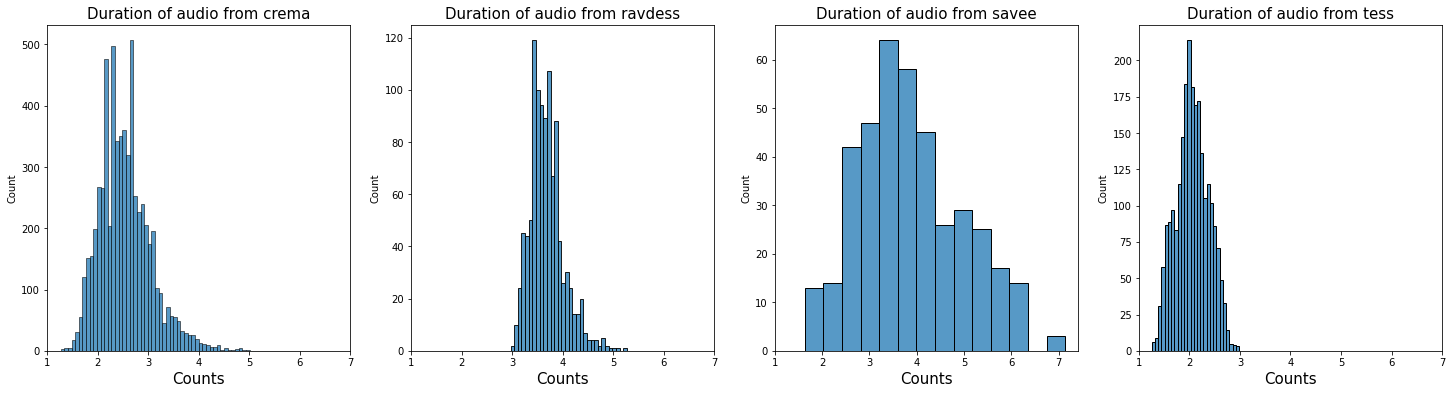

In [7]:
fig, axs = plt.subplots(1, 4, figsize = (25,6))

c = 0
for origin in np.unique(train_df['origin']):
    sns.histplot(ax = axs[c], x = train_df[train_df['origin']==origin]['duration'])
    axs[c].set_title('Duration of audio from ' + origin, size = 15)
    axs[c].set_xticks(np.linspace(1, 7, 7))
    axs[c].set_xlabel('Duration', size = 15)
    axs[c].set_xlabel('Counts', size = 15)
    c+=1

The distribution of the durations of the files from savee has a far higher standard deviations with reference to the other origins.

In [8]:
print('maximum duration:', train_df['duration'].max().round(2))
print('96 precentile duration:', train_df['duration'].quantile(.96).round(2))

maximum duration: 7.14
96 precentile duration: 3.97


Having a look at how the emotions are distribuited with reference to the origin.

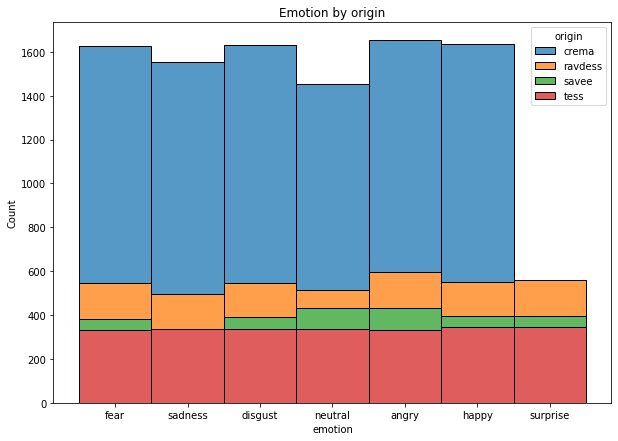

In [12]:
plt.figure(figsize = (10,7))
sns.histplot(data = train_df, x='emotion', hue = 'origin', multiple='stack')
plt.title('Emotion by origin')
plt.show()

The distribuiton of the emotions is really unbalanced because the biggest dataset (crema) does not contain samples of surprise.

Furthermore the the savee dataset does not contain samples of sadness.

Let's now have a look to the pairplots between the features to see if there are evident correlations.

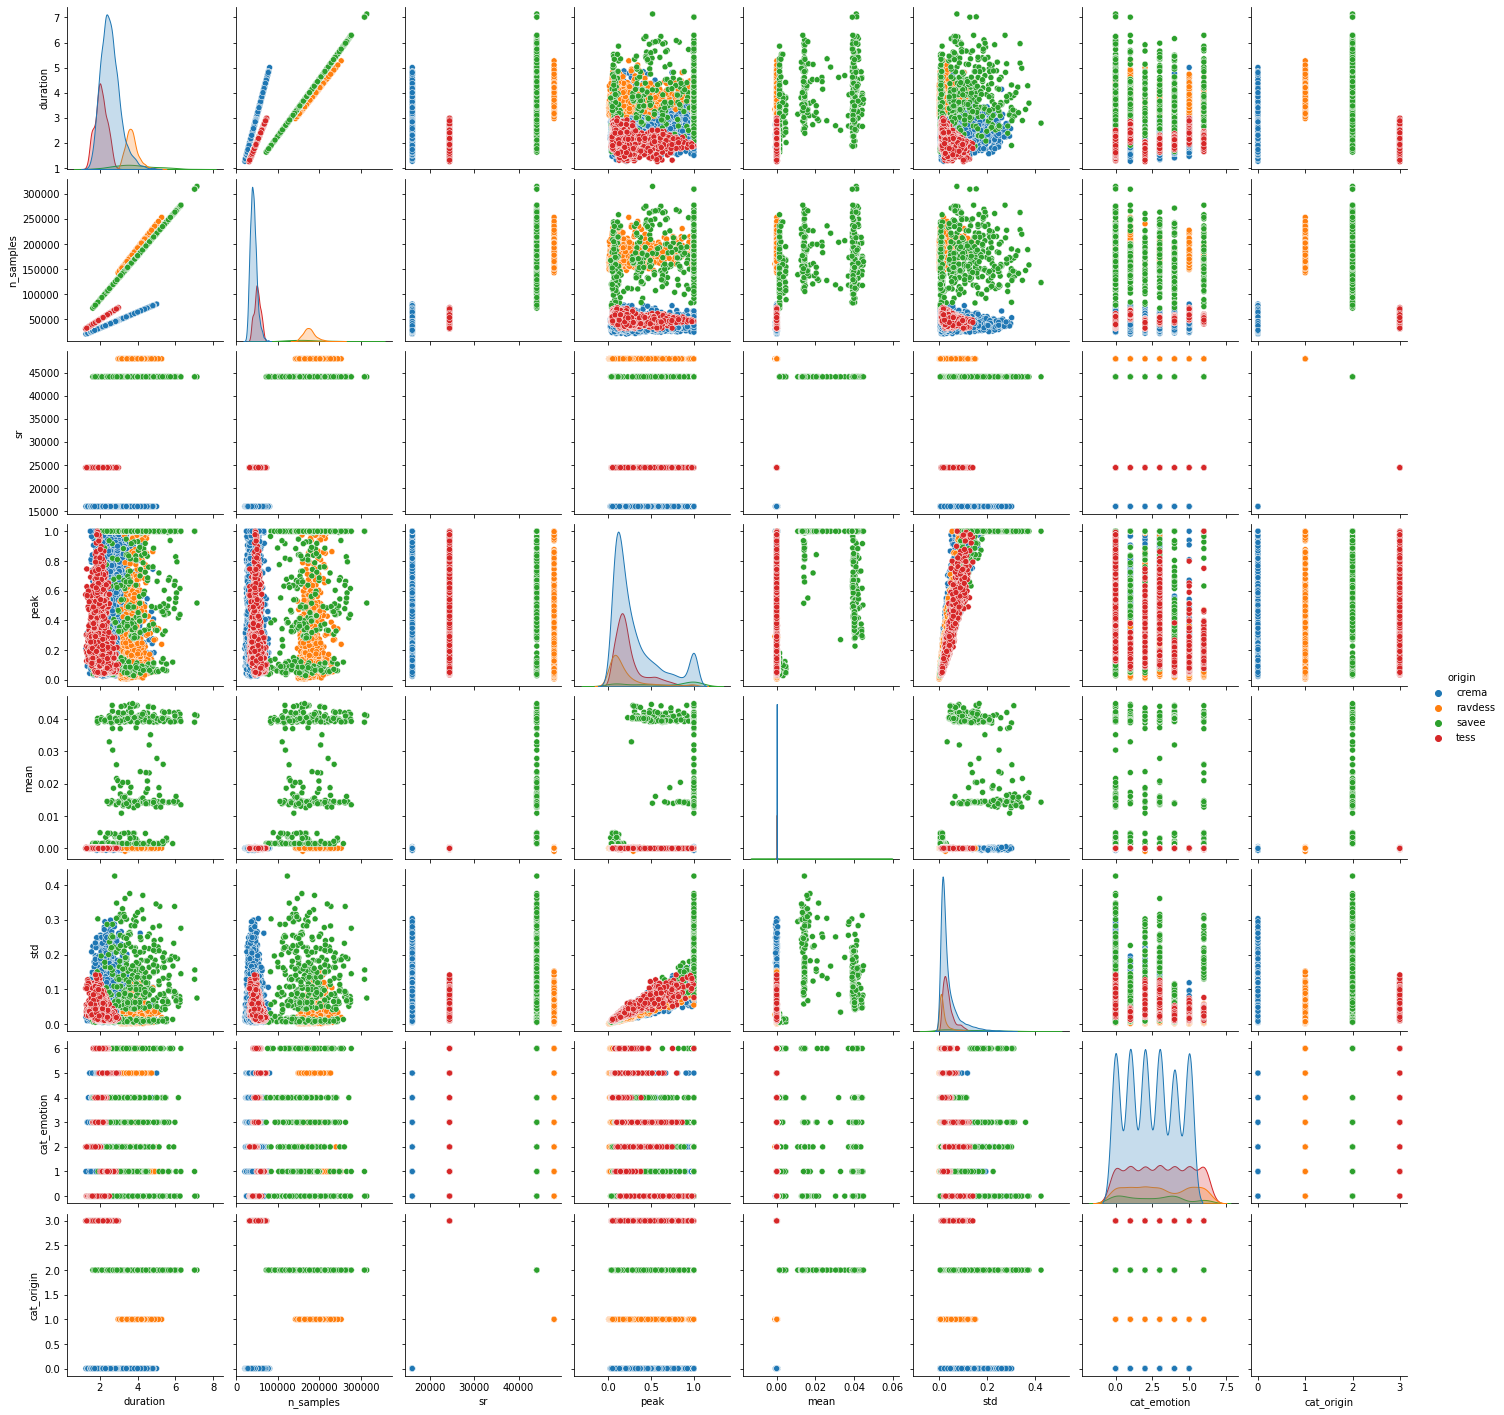

In [13]:
sns.pairplot(train_df, hue = 'origin')
plt.show()

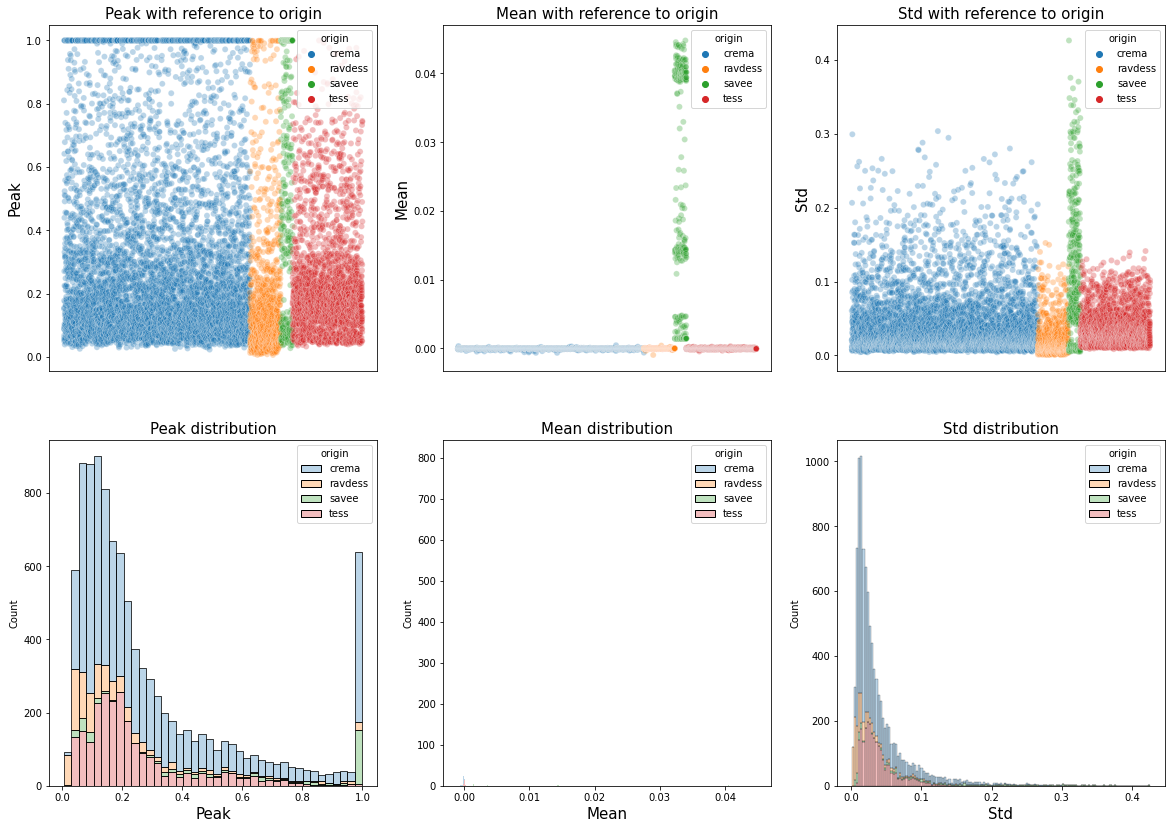

In [23]:
fig, axs = plt.subplots(2, 3, figsize = (20, 14))

sns.scatterplot(ax = axs[0,0], x = range(len(train_df)), y = peak, hue = train_df['origin'], alpha = 0.3)
axs[0,0].set_title('Peak with reference to origin', size = 15)
axs[0,0].set_xticks([])
axs[0,0].set_ylabel('Peak', size = 15)

sns.scatterplot(ax = axs[0,1], x = range(len(train_df)), y = mean, hue = train_df['origin'], alpha = 0.3)
axs[0,1].set_title('Mean with reference to origin', size = 15)
axs[0,1].set_xticks([])
axs[0,1].set_ylabel('Mean', size = 15)

sns.scatterplot(ax = axs[0,2], x = range(len(train_df)), y = std, hue = train_df['origin'], alpha = 0.3)
axs[0,2].set_title('Std with reference to origin', size = 15)
axs[0,2].set_xticks([])
axs[0,2].set_ylabel('Std', size = 15)

sns.histplot(ax = axs[1,0], x = peak, hue = train_df['origin'], multiple = 'stack', alpha = 0.3)
axs[1,0].set_title('Peak distribution', size = 15)
axs[1,0].set_xlabel('Peak', size = 15)

sns.histplot(ax = axs[1,1], x = mean, hue = train_df['origin'], multiple = 'stack', alpha = 0.3)
axs[1,1].set_title('Mean distribution', size = 15)
axs[1,1].set_xlabel('Mean', size = 15)

sns.histplot(ax = axs[1,2], x = std, hue = train_df['origin'], multiple = 'stack', alpha = 0.3)
axs[1,2].set_title('Std distribution', size = 15)
axs[1,2].set_xlabel('Std', size = 15)

plt.show()

There is an evident correlation between the origin and the characteristics of the audio files.
For instance, the audio from savee have a higher mean and std with reference to the other origins. It could mean that the registrations are more noisy.

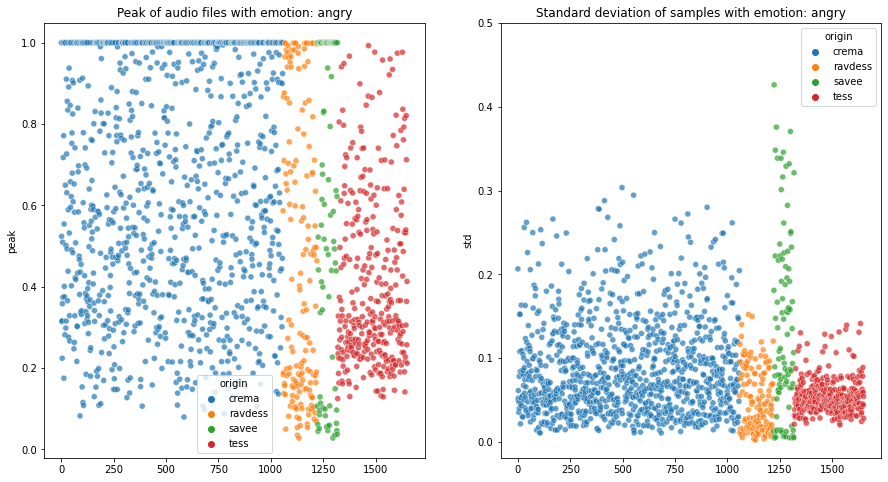

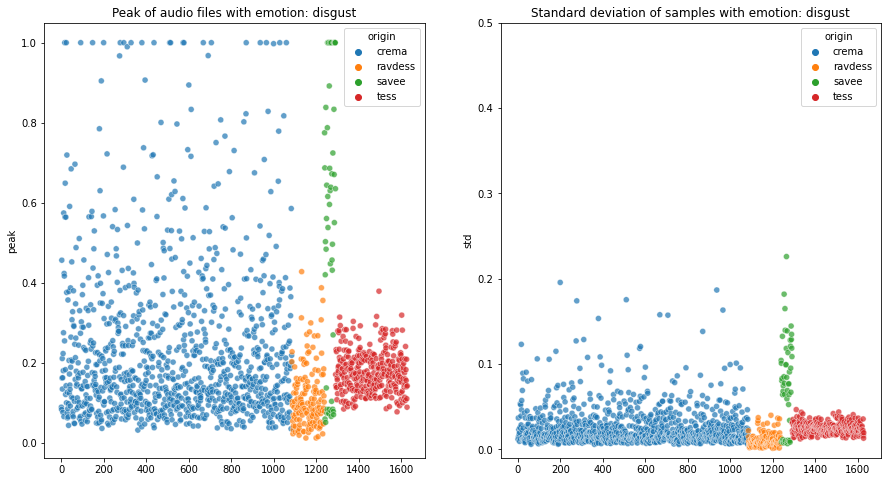

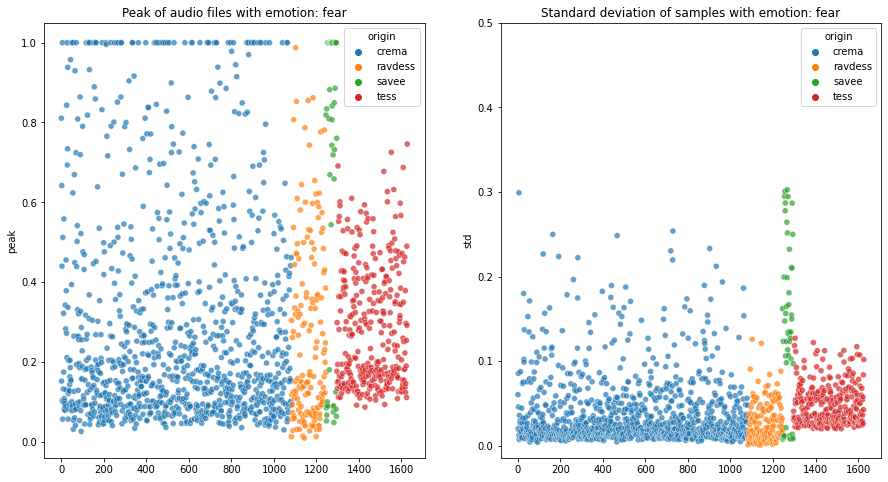

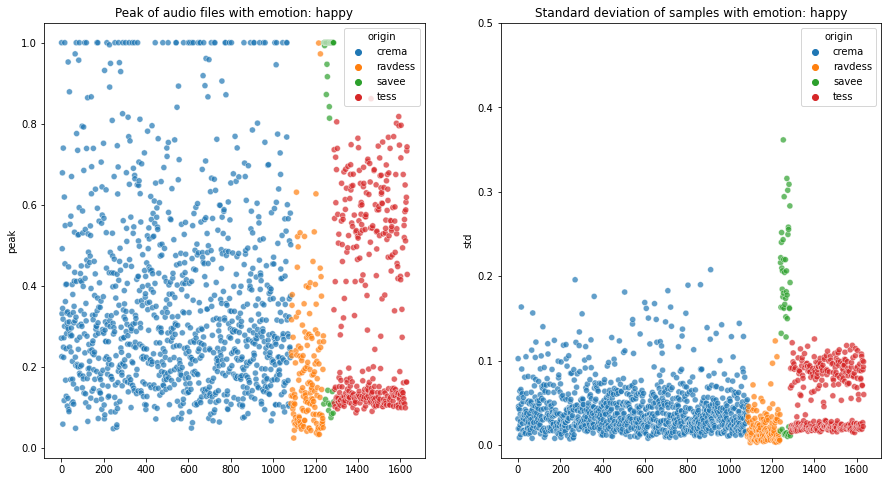

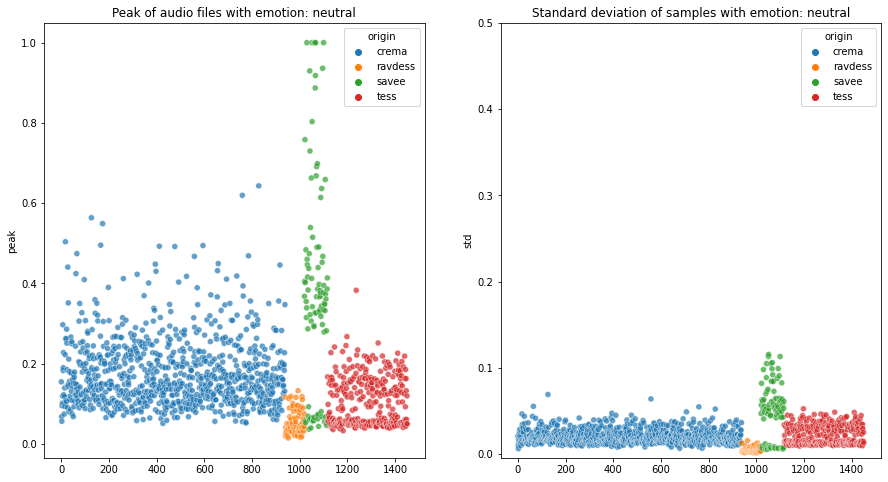

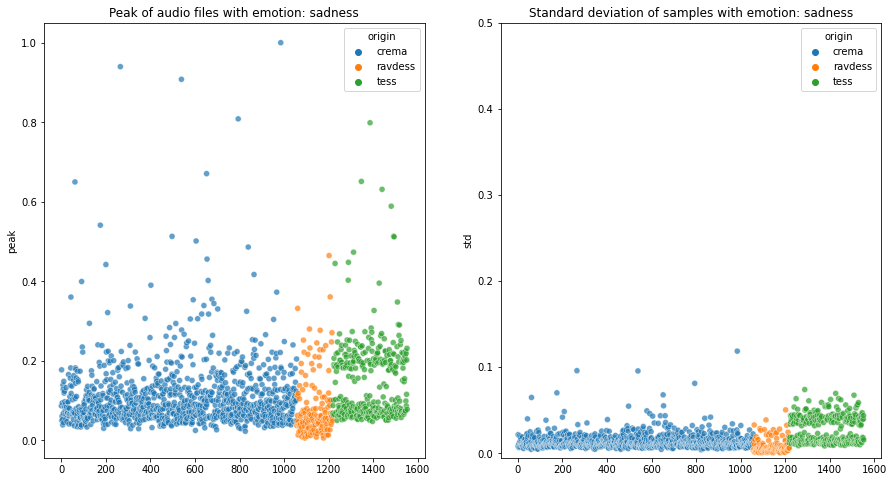

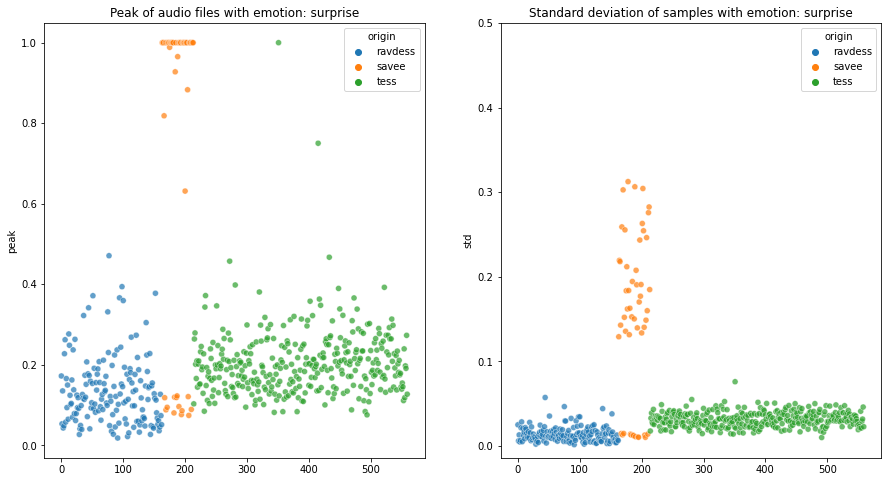

In [12]:
for em in ems:
    mask = train_df['emotion'] == em
    fig, axs = plt.subplots(1,2, figsize = (15,8))
    sns.scatterplot(ax = axs[0], x = range(len(train_df[mask])), y = peak[mask], hue=train_df['origin'][mask], alpha = 0.7)
    sns.scatterplot(ax = axs[1], x = range(len(train_df[mask])), y = std[mask], hue=train_df['origin'][mask], alpha = 0.7)
    axs[0].set_title('Peak of audio files with emotion: '+ em)
    axs[1].set_title('Standard deviation of samples with emotion: '+ em)
    axs[0].set_ylabel('peak')
    axs[0].set_yticks(np.linspace(0,1,6))
    axs[1].set_ylabel('std')
    axs[1].set_yticks(np.linspace(0,0.5,6))
    plt.show()

There is correlation even between the volume (peak and std) and the corresponding emotion.
As a consequence normalize the volume could result in loss of information.

#### Studying the test set

In [14]:
test_df = pd.read_csv(main_dir+'\\2022challengeA_test.csv', index_col=0)
test_dir = main_dir + '\\test'

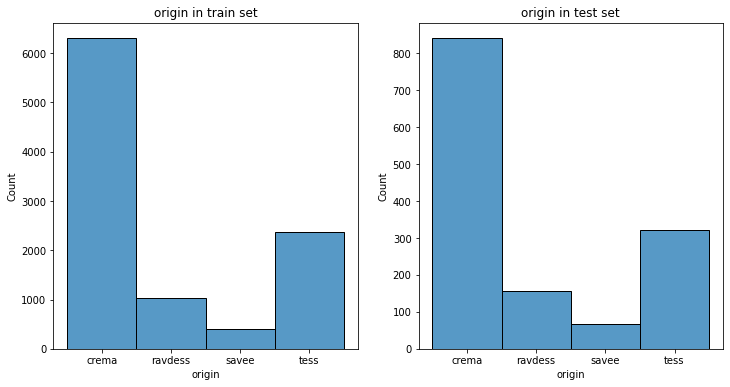

In [24]:
fig ,axs = plt.subplots(1, 2, figsize = (12, 6))

sns.histplot(ax = axs[0], x = train_df['origin'])
axs[0].set_title('origin in train set')

sns.histplot(ax = axs[1], x = test_df['origin'])
axs[1].set_title('origin in test set')

plt.show()

In [27]:
# Initialize mean, peak, std, number of samples, sampling rate and duration

duration = np.zeros(shape = len(test_df))
n_samples = np.zeros(shape = len(test_df))
sampling_rate = np.zeros(shape = len(test_df))
peak = np.zeros(shape = len(test_df))
mean = np.zeros(shape = len(test_df))
std = np.zeros(shape = len(test_df))


for i in range(len(test_df)):
    audio_file = test_dir + '\\' + test_df['file_id'][i]
    samples, sr = librosa.load(audio_file, sr=None)
    duration[i] = len(samples)/sr
    n_samples[i] = len(samples)
    sampling_rate[i] = sr
    peak[i] = np.max(np.abs(samples))
    mean[i] = np.mean(samples)
    std[i] = np.std(samples)

test_df['duration']=duration
test_df['n_samples']=n_samples.astype(int)
test_df['sr']=sampling_rate
test_df['peak']=peak
test_df['mean']=mean
test_df['std']=std

# Adding a categorical encoding of origin

cat_origin=np.zeros(len(test_df))

ors = list(np.unique(test_df['origin']))
for i in range(len(test_df)):
    cat_origin[i]=ors.index(test_df['origin'][i])

test_df['cat_origin']=cat_origin.astype(int)

# Let's see a sample of the dataset

display(test_df.sample(10))

,file_id,origin,predicted_emotion,duration,n_samples,sr,peak,mean,std,cat_emotion,cat_origin
1361,26867751-cbab-4b8b-8928-7f3d82adb76b.wav,tess,NaN,1.831081,44704,24414.0,0.290100,0.000014,0.052167,0,3
857,dbacdd49-ea6f-4f7b-b8f4-a0f4d4ec43fe.wav,ravdess,NaN,4.371042,209810,48000.0,0.563538,0.000002,0.053758,0,1
586,61dc6b54-ee4d-4374-976b-9892a3642abe.wav,crema,NaN,2.268937,36303,16000.0,0.050354,-0.000024,0.007838,0,0
570,53882ca7-2bc3-4fa3-aacc-2a047badd8ed.wav,crema,NaN,3.036375,48582,16000.0,0.207397,-0.000018,0.021163,0,0
531,03f1223f-3e6d-4670-b369-96e60cb84e45.wav,crema,NaN,2.068750,33100,16000.0,0.154938,-0.000059,0.020334,0,0
95,e999823f-90ab-4d4b-811c-5873534cd225.wav,crema,NaN,2.635937,42175,16000.0,0.124512,-0.000034,0.014273,0,0
890,4d74d602-a555-469f-9570-0414e0bc233b.wav,ravdess,NaN,3.703708,177778,48000.0,0.044678,0.000002,0.005992,0,1
523,4bbe7351-acfd-4f24-bf57-a88cfa156743.wav,crema,NaN,2.769437,44311,16000.0,0.573029,-0.000034,0.089245,0,0
213,f6603cd1-5e63-4ef7-a245-1e37a26dc2e4.wav,crema,NaN,2.369000,37904,16000.0,0.262848,-0.000016,0.037146,0,0
1007,705b95b6-184e-4589-b5bb-35e0747f78cf.wav,savee,NaN,2.473787,109094,44100.0,0.100433,0.001498,0.011051,0,2


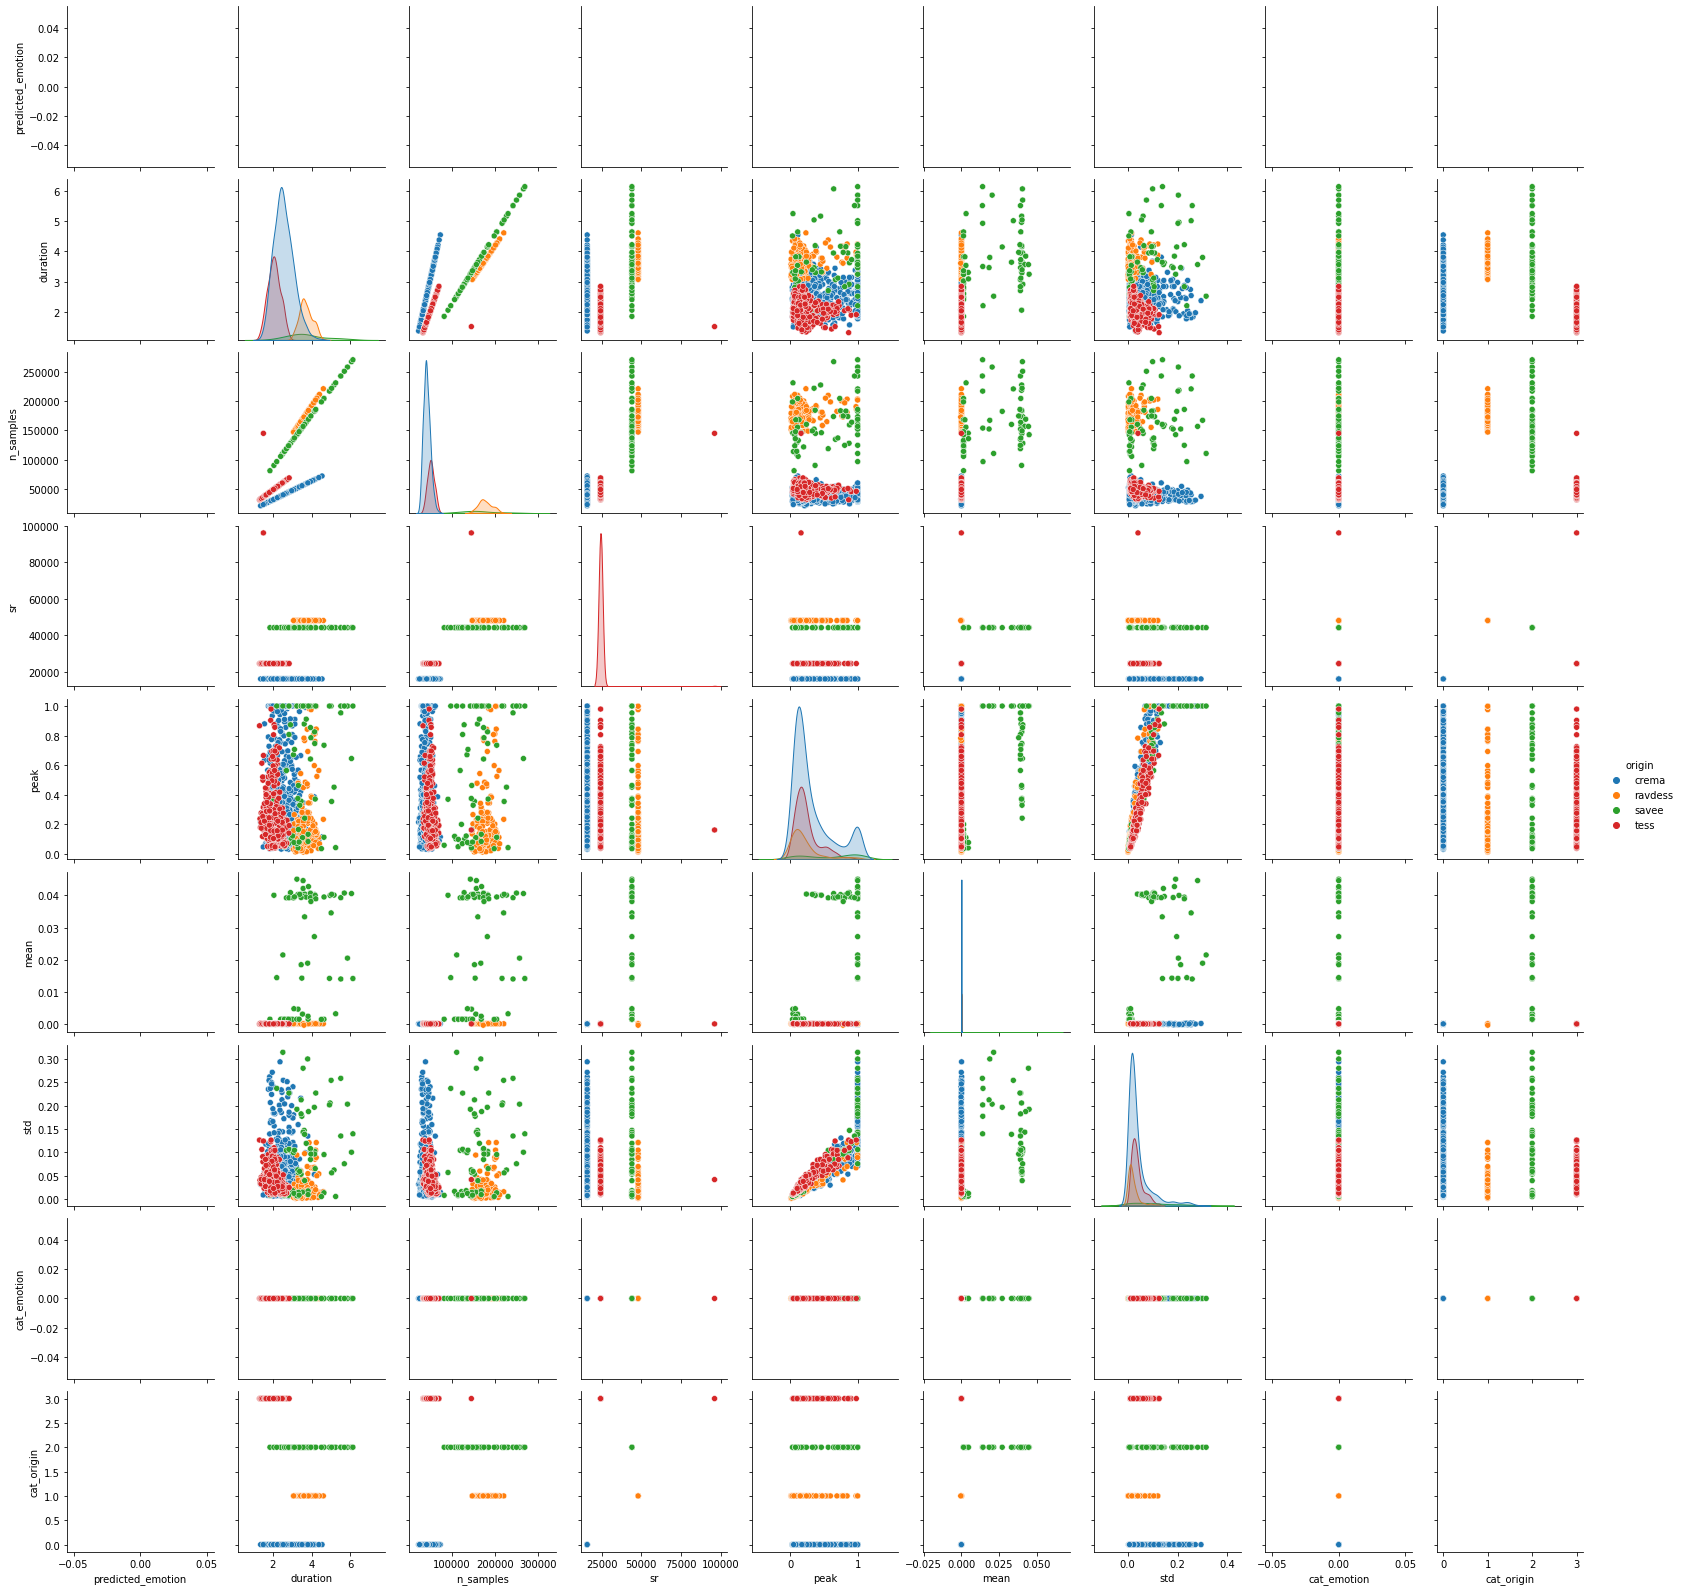

In [31]:
sns.pairplot(test_df, hue = 'origin')
plt.show()

There are not evident differences among the train and the test set.